## Import Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model, layers, models, initializers
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Add, Input, Lambda
from keras.datasets import mnist
import cv2

# Enable GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [3]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import kagglehub

# Download the latest version of the CelebA dataset
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# print("Path to dataset files:", path)
path = "/Users/yfahmy/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/"
base_dir = os.path.join(path, "img_align_celeba") 

# Image size to resize all images to
image_dim = 200
num_channels = 3
images = []

# Optional: limit number of images if needed
MAX_IMAGES = 10000

# Loop through images in the dataset directory
for i, filename in enumerate(os.listdir(base_dir)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(base_dir, filename)

        try:
            img = Image.open(image_path).convert("RGB")
            img = img.resize((image_dim, image_dim))
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

        if i + 1 >= MAX_IMAGES:
            break

# Convert list to numpy array
images = np.array(images)

# Split into training and testing sets
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Ensure the correct shape for TensorFlow (batch, height, width, channels)
x_train = x_train.reshape(len(x_train), image_dim, image_dim, num_channels)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, num_channels)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

/opt/homebrew/anaconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


x_train shape: (8000, 200, 200, 3), x_test shape: (2000, 200, 200, 3)


## Add Gaussian Blur

In [4]:
def add_gaussian_blur_batch(images, kernel_size=(5, 5), sigma=5.0):
    blurred_images = np.empty_like(images)
    for i in range(images.shape[0]):
        blurred_images[i] = cv2.GaussianBlur(images[i], kernel_size, sigma)
    return blurred_images

x_train_noisy = add_gaussian_blur_batch(x_train)
x_test_noisy = add_gaussian_blur_batch(x_test)

## Add Gaussian Noise

In [5]:
noise_factor = 0.075
x_train_noisy = x_train_noisy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test_noisy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

## Add Salt and Pepper Noise

In [6]:
def add_s_and_p_noise_batch(images, salt_prob=0.01, pepper_prob=0.01):
    N, H, W, C = images.shape
    rand_matrix = np.random.rand(N, H, W)
    salt_mask = rand_matrix < salt_prob
    pepper_mask = rand_matrix > (1 - pepper_prob)
    images[salt_mask] = 255
    images[pepper_mask] = 0
    return images

x_train_noisy = add_s_and_p_noise_batch(x_train_noisy)
x_test_noisy = add_s_and_p_noise_batch(x_test_noisy)

In [7]:
# clip the values in the range of 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Exploratory Data Analysis

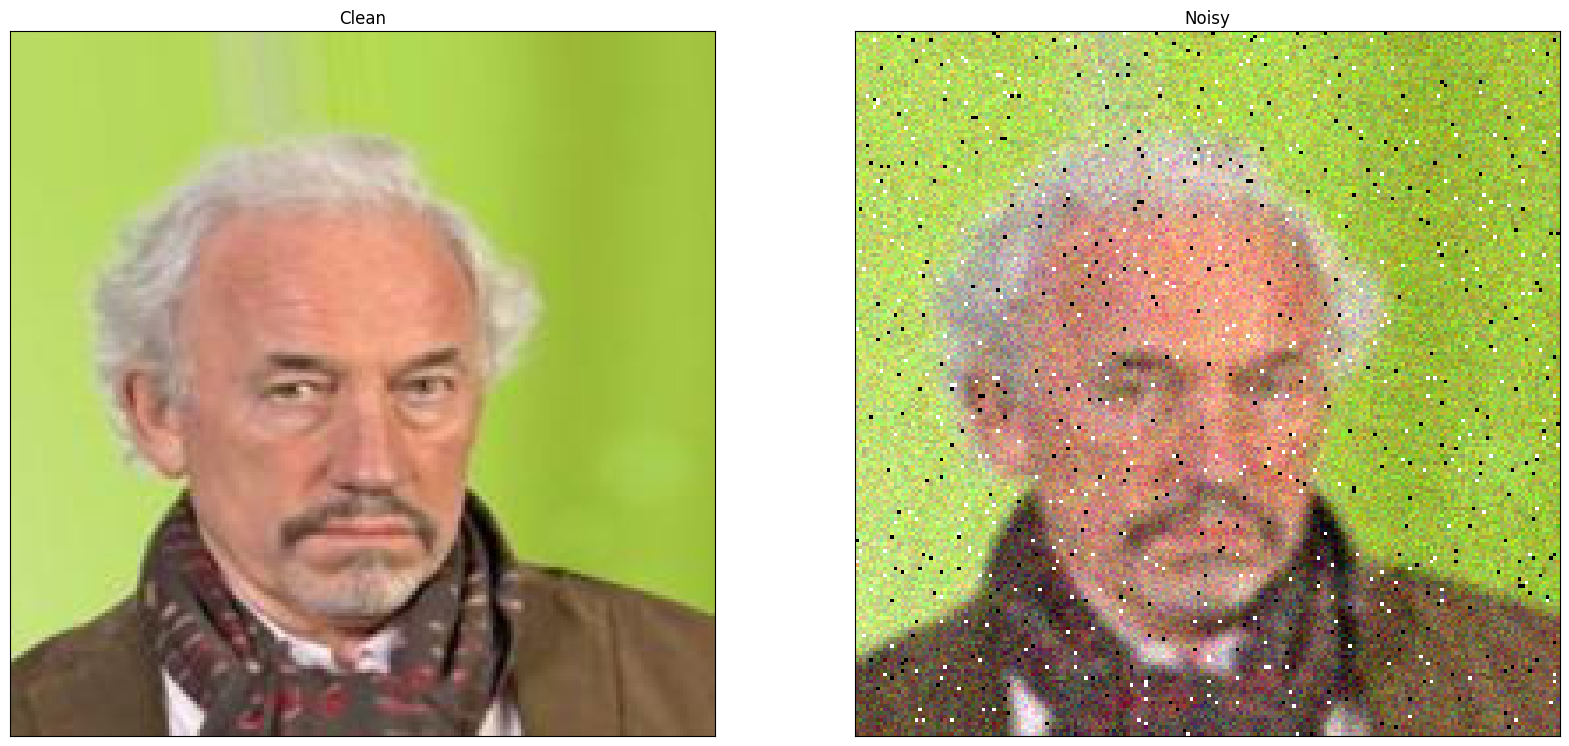

In [8]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 2, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
plt.show()

## Model Creation

In [9]:
input_img = Input(shape=(image_dim, image_dim, num_channels))  # RGB images

# First layer (Conv + ReLU)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)


x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)


# Last layer (Conv, No Activation)
x = Conv2D(3, (3, 3), padding='same')(x)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, x])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss='mse')
model.summary()

2025-03-28 15:51:54.160623: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-03-28 15:51:54.160670: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-28 15:51:54.160674: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-03-28 15:51:54.160690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-28 15:51:54.160705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 200, 200,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 200,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 200, 200,  │     18,464 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 200, 200,  │      4,624 │ re_lu_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 200, 200,  │      2,320 │ re_lu_3[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 200, 200,  │      4,640 │ re_lu_4[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        128 │ conv2d_5[0][0]  

 Total params: 89,891 (351.14 KB)

 Trainable params: 89,443 (349.39 KB)

 Non-trainable params: 448 (1.75 KB)

## Train the model

In [10]:
model.fit(x_train_noisy, x_train, epochs=100 , batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))
model.save("trained_models/celeba_cnn_unet.keras")

Epoch 1/100


2025-03-28 15:52:20.447497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-28 15:52:20.455784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0965

2025-03-28 15:55:41.845508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


125/125 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - loss: 0.0960 - val_loss: 0.0133
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 0.0102 - val_loss: 0.0114
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 0.0068 - val_loss: 0.0087
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 0.0055 - val_loss: 0.0062
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0046 - val_loss: 0.0048
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 0.0040 - val_loss: 0.0047
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0034 - val_loss: 0.0040
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 0.0026 - val_loss: 0.0031
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0024 - val_loss: 0.0026
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 

## Visualize the Results

In [11]:
# predict the results from model (get compressed images)
pred = model.predict(x_test_noisy)

2025-03-28 21:21:39.984458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.058132812..1.0935718].


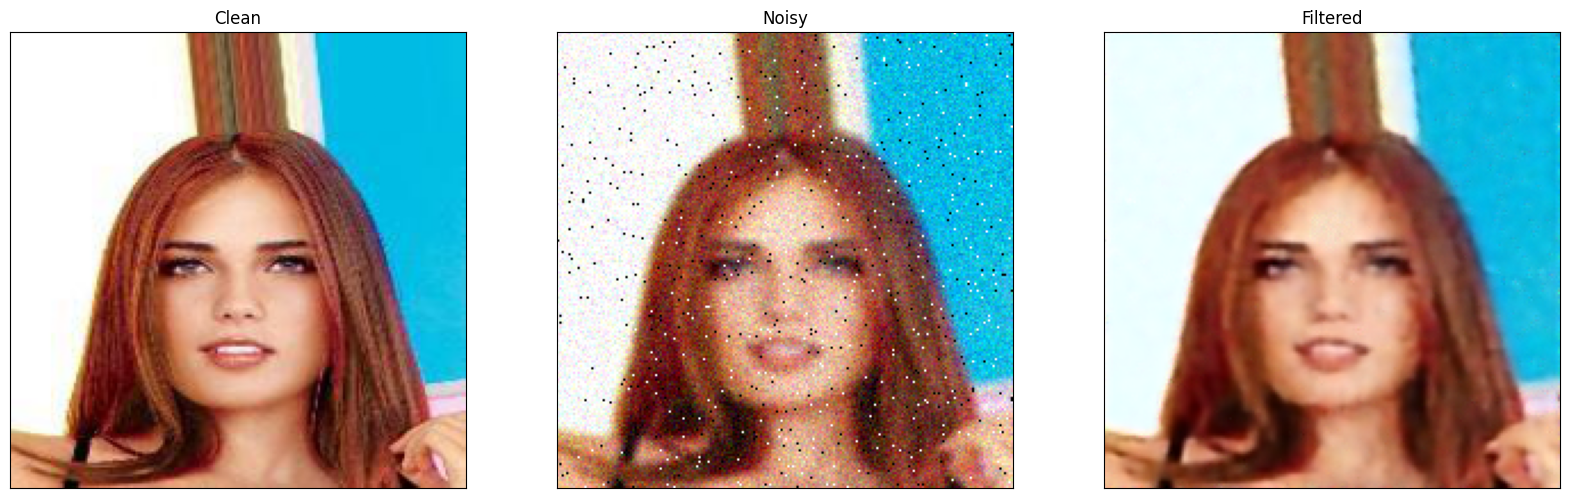

In [12]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 3, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
# display cleaned image
ax = plt.subplot(1, 3, 3)
plt.imshow(pred[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Filtered")
plt.show()

## Evaluate the Model

In [13]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Generate model predictions
x_pred = model.predict(x_test_noisy)

# Clip to valid range (e.g. 0-1 or 0-255 depending on preprocessing)
x_pred = np.clip(x_pred, 0, 1)
x_test = np.clip(x_test, 0, 1)

# Calculate average PSNR and SSIM
psnr_total = 0
ssim_total = 0
for i in range(len(x_test)):
    psnr_total += psnr(x_test[i], x_pred[i], data_range=1.0)
    ssim_total += ssim(x_test[i], x_pred[i], channel_axis=-1, data_range=1.0)

avg_psnr = psnr_total / len(x_test)
avg_ssim = ssim_total / len(x_test)

print("Avg PSNR:", avg_psnr)
print("Avg SSIM:", avg_ssim)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step
Avg PSNR: 29.06730936763556
Avg SSIM: 0.8296461910307408
